In [15]:
# Ashley Mayo
# March 2nd, 2025
# DSC 640: Data Presentation and Visualization

In [40]:
# Import libraries
import pandas as pd
import geodatasets
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from IPython.display import display

In [72]:
# Load the dataset (Assuming the user already has it in the notebook)
file_path = os.path.join(os.getcwd(), "NDCP2022.xlsx")
sheet_name = "County_LevelNDCP_v8_update2008_"

full_data = pd.read_excel(file_path, sheet_name=sheet_name, usecols=[
    "STATE_NAME", "STATE_ABBREVIATION", "STUDYYEAR", "TOTALPOP", "HOUSEHOLDS", 
    "MCTODDLER", "MCPRESCHOOL", "EMP_SERVICE", "EMP_SALES", "FLFPR_20to64"
])

full_data.head()

,STATE_NAME,STATE_ABBREVIATION,STUDYYEAR,FLFPR_20to64,TOTALPOP,HOUSEHOLDS,EMP_SERVICE,EMP_SALES,MCTODDLER,MCPRESCHOOL
0,Alabama,AL,2008,68.9,49744,18373,17.1,29.1,104.95,85.92
1,Alabama,AL,2009,70.8,49584,18288,15.8,28.8,105.11,87.59
2,Alabama,AL,2010,71.3,53155,19718,16.9,29.1,105.28,89.26
3,Alabama,AL,2011,70.2,53944,19998,16.2,27.6,105.45,90.93
4,Alabama,AL,2012,70.6,54590,19934,16.1,28.4,105.61,92.60


In [73]:
# Compute state-level weighted averages
state_avg_costs = full_data.groupby("STATE_NAME", as_index=False).agg(
    MCTODDLER_Weighted=("MCTODDLER", lambda x: np.average(x, weights=full_data.loc[x.index, "TOTALPOP"])),
    MCPRESCHOOL_Weighted=("MCPRESCHOOL", lambda x: np.average(x, weights=full_data.loc[x.index, "TOTALPOP"])),
    MCTODDLER_per_Household=("MCTODDLER", lambda x: np.average(x, weights=full_data.loc[x.index, "HOUSEHOLDS"])),
    MCPRESCHOOL_per_Household=("MCPRESCHOOL", lambda x: np.average(x, weights=full_data.loc[x.index, "HOUSEHOLDS"])),
    EMP_Service_Avg=("EMP_SERVICE", "mean"),
    EMP_Sales_Avg=("EMP_SALES", "mean")
)

# Display results
state_avg_costs.head()

,STATE_NAME,MCTODDLER_Weighted,MCPRESCHOOL_Weighted,MCTODDLER_per_Household,MCPRESCHOOL_per_Household,EMP_Service_Avg,EMP_Sales_Avg
0,Alabama,116.862178,107.345967,116.920203,107.377773,16.321891,22.270746
1,Alaska,NaN,NaN,NaN,NaN,17.870938,19.757208
2,Arizona,181.498829,163.340227,181.333177,163.385532,21.665778,23.165333
3,Arkansas,NaN,NaN,NaN,NaN,17.334489,21.282578
4,California,NaN,NaN,NaN,NaN,20.142414,22.045287


In [74]:
# Define quartile-based cost thresholds
high_threshold = state_avg_costs["MCTODDLER_Weighted"].quantile(0.75)
low_threshold = state_avg_costs["MCTODDLER_Weighted"].quantile(0.25)

# Categorize states based on cost thresholds
state_avg_costs["Cost_Category"] = state_avg_costs["MCTODDLER_Weighted"].apply(
    lambda x: "High-Cost" if x >= high_threshold else ("Low-Cost" if x <= low_threshold else "Mid-Cost")
)

# Display category counts
state_avg_costs["Cost_Category"].value_counts()

Cost_Category
Mid-Cost     42
Low-Cost      5
High-Cost     5
Name: count, dtype: int64

In [75]:
# Sort states based on childcare costs
top_5_expensive = state_avg_costs.nlargest(5, "MCTODDLER_Weighted")
bottom_5_expensive = state_avg_costs.nsmallest(5, "MCTODDLER_Weighted")

# Combine for visualization
filtered_states = pd.concat([bottom_5_expensive, top_5_expensive])

In [76]:
# Select Top 10 High-Cost & Bottom 10 Low-Cost States
top_10 = state_avg_costs.nlargest(10, "MCTODDLER_Weighted")
bottom_10 = state_avg_costs.nsmallest(10, "MCTODDLER_Weighted")

# Remove extremely low childcare costs (likely data errors)
filtered_data = full_data[(full_data["MCTODDLER"] > 50) & (full_data["MCPRESCHOOL"] > 50)]

# Recalculate state averages
state_avg_costs = filtered_data.groupby("STATE_NAME", as_index=False).agg(
    MCTODDLER_Weighted=("MCTODDLER", lambda x: np.average(x, weights=filtered_data.loc[x.index, "TOTALPOP"])),
    MCPRESCHOOL_Weighted=("MCPRESCHOOL", lambda x: np.average(x, weights=filtered_data.loc[x.index, "TOTALPOP"]))
)

# Display data
filtered_states

,STATE_NAME,MCTODDLER_Weighted,MCPRESCHOOL_Weighted,MCTODDLER_per_Household,MCPRESCHOOL_per_Household,EMP_Service_Avg,EMP_Sales_Avg,Cost_Category
17,Kentucky,114.970016,114.970016,115.201943,115.201943,16.668167,21.575000,Low-Cost
0,Alabama,116.862178,107.345967,116.920203,107.377773,16.321891,22.270746,Low-Cost
43,Tennessee,121.233616,121.233616,121.199850,121.199850,16.971158,21.984912,Low-Cost
18,Louisiana,121.639772,117.368081,121.742910,117.460911,19.253542,22.398854,Low-Cost
49,West Virginia,126.163970,123.715052,125.900611,123.465846,19.214061,21.901818,Low-Cost
21,Massachusetts,328.164300,260.000541,328.102264,259.871430,18.008095,22.159524,High-Cost
6,Connecticut,286.549227,231.554610,285.750722,231.067017,17.520000,22.780833,High-Cost
48,Washington,245.895256,219.827319,246.476203,220.458575,18.522051,21.102393,High-Cost
23,Minnesota,239.098249,215.196232,238.178101,214.395097,17.147356,21.085057,High-Cost
30,New Jersey,223.125779,207.256670,223.403517,207.644903,16.795238,24.068889,High-Cost


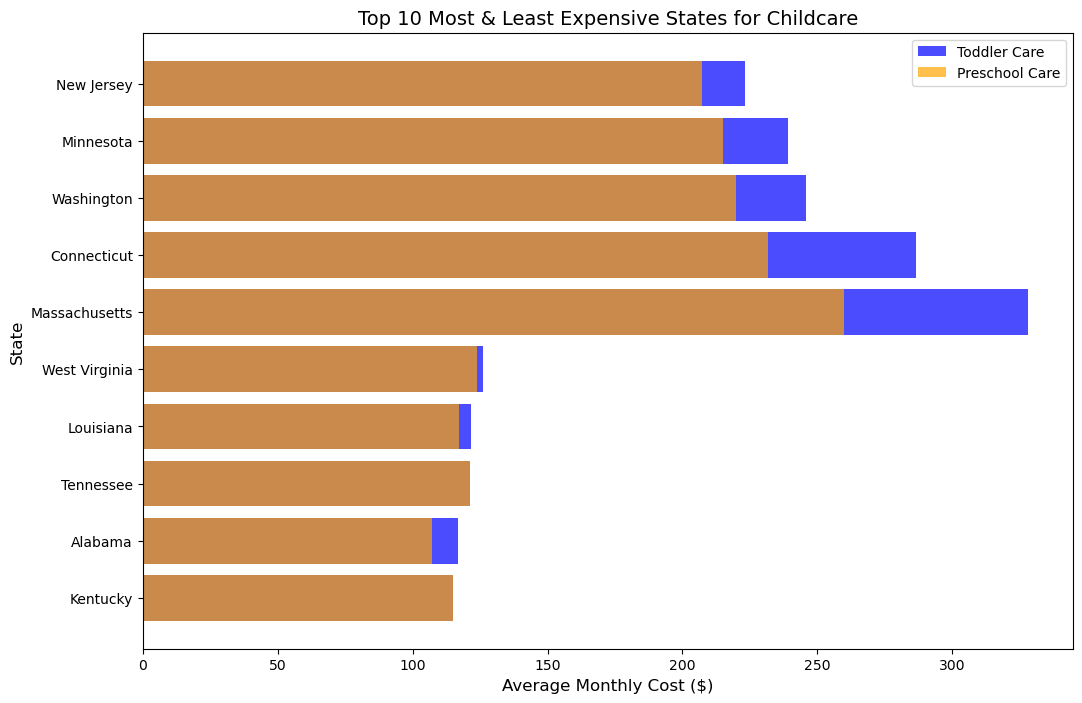

In [77]:
# Set up consistent colors
colors = {
    "High-Cost": "red",
    "Mid-Cost": "orange",
    "Low-Cost": "green"
}

# Create bar chart for childcare costs
plt.figure(figsize=(12, 8))
plt.barh(filtered_states["STATE_NAME"], filtered_states["MCTODDLER_Weighted"], color="blue", alpha=0.7, label="Toddler Care")
plt.barh(filtered_states["STATE_NAME"], filtered_states["MCPRESCHOOL_Weighted"], color="orange", alpha=0.7, label="Preschool Care")

plt.xlabel("Average Monthly Cost ($)", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.title("Top 10 Most & Least Expensive States for Childcare", fontsize=14)
plt.legend()
plt.show()


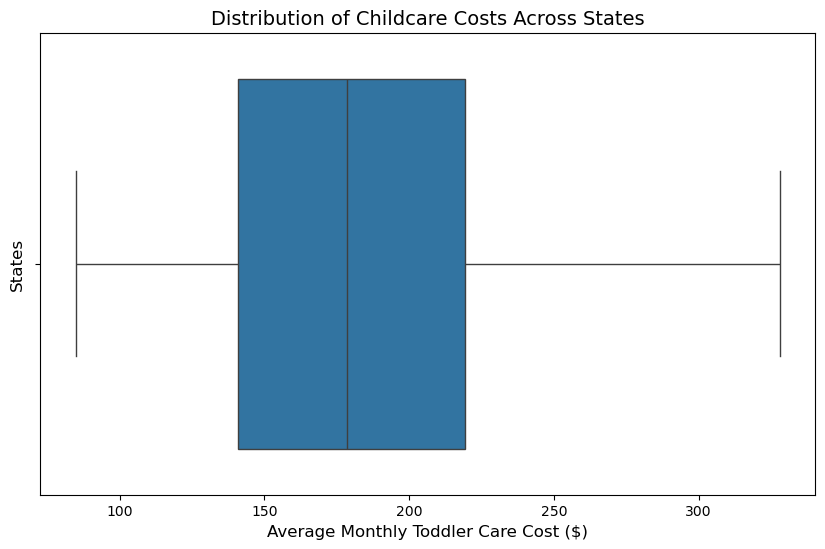

In [78]:
plt.figure(figsize=(10,6))
sns.boxplot(x=state_avg_costs["MCTODDLER_Weighted"])

plt.xlabel("Average Monthly Toddler Care Cost ($)", fontsize=12)
plt.ylabel("States", fontsize=12)
plt.title("Distribution of Childcare Costs Across States", fontsize=14)
plt.show()

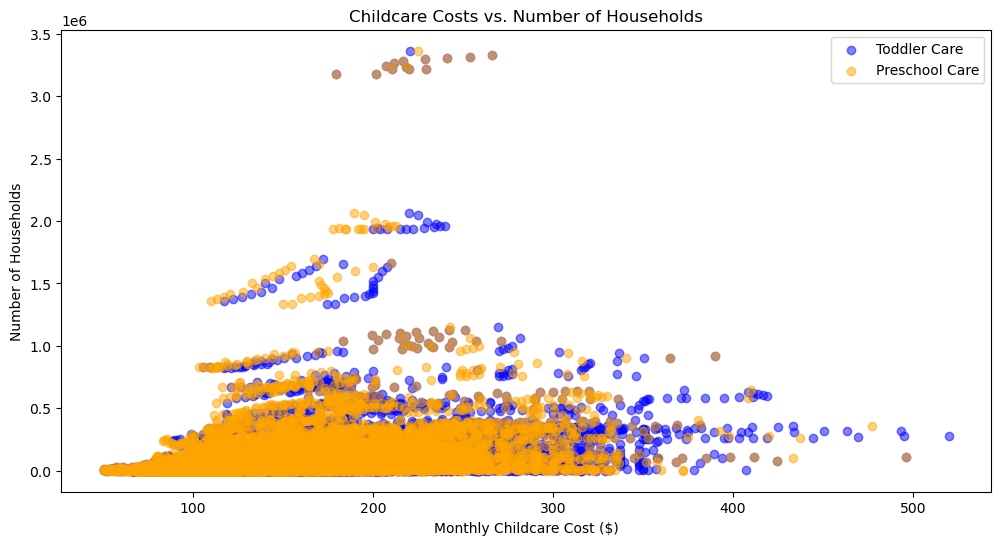

In [79]:
plt.figure(figsize=(12, 6))
plt.scatter(filtered_data["MCTODDLER"], filtered_data["HOUSEHOLDS"], alpha=0.5, color="blue", label="Toddler Care")
plt.scatter(filtered_data["MCPRESCHOOL"], filtered_data["HOUSEHOLDS"], alpha=0.5, color="orange", label="Preschool Care")

plt.xlabel("Monthly Childcare Cost ($)")
plt.ylabel("Number of Households")
plt.title("Childcare Costs vs. Number of Households")
plt.legend()
plt.show()


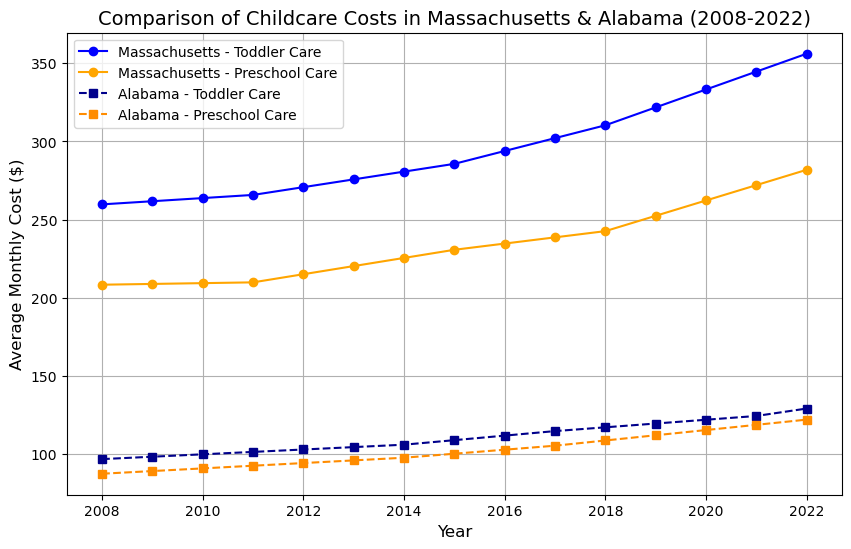

In [80]:
# Filter for only Puerto Rico and Massachusetts
selected_states = ["Alabama", "Massachusetts"]
changed_data = full_data[full_data["STATE_NAME"].isin(selected_states)]

# Group by year and state, then calculate the average cost
state_trends = changed_data.groupby(["STUDYYEAR", "STATE_NAME"]).agg(
    Toddler_Avg=("MCTODDLER", "mean"),
    Preschool_Avg=("MCPRESCHOOL", "mean")
).reset_index()

plt.figure(figsize=(10, 6))

# Plot for Massachusetts
massachusetts = state_trends[state_trends["STATE_NAME"] == "Massachusetts"]
plt.plot(massachusetts["STUDYYEAR"], massachusetts["Toddler_Avg"], marker='o', color='blue', label="Massachusetts - Toddler Care")
plt.plot(massachusetts["STUDYYEAR"], massachusetts["Preschool_Avg"], marker='o', color='orange', label="Massachusetts - Preschool Care")

# Plot for Alabama
alabama = state_trends[state_trends["STATE_NAME"] == "Alabama"]
plt.plot(alabama["STUDYYEAR"], alabama["Toddler_Avg"], marker='s', color='darkblue', linestyle="dashed", label="Alabama - Toddler Care")
plt.plot(alabama["STUDYYEAR"], alabama["Preschool_Avg"], marker='s', color='darkorange', linestyle="dashed", label="Alabama - Preschool Care")

# Labels & Formatting
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Monthly Cost ($)", fontsize=12)
plt.title("Comparison of Childcare Costs in Massachusetts & Alabama (2008-2022)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

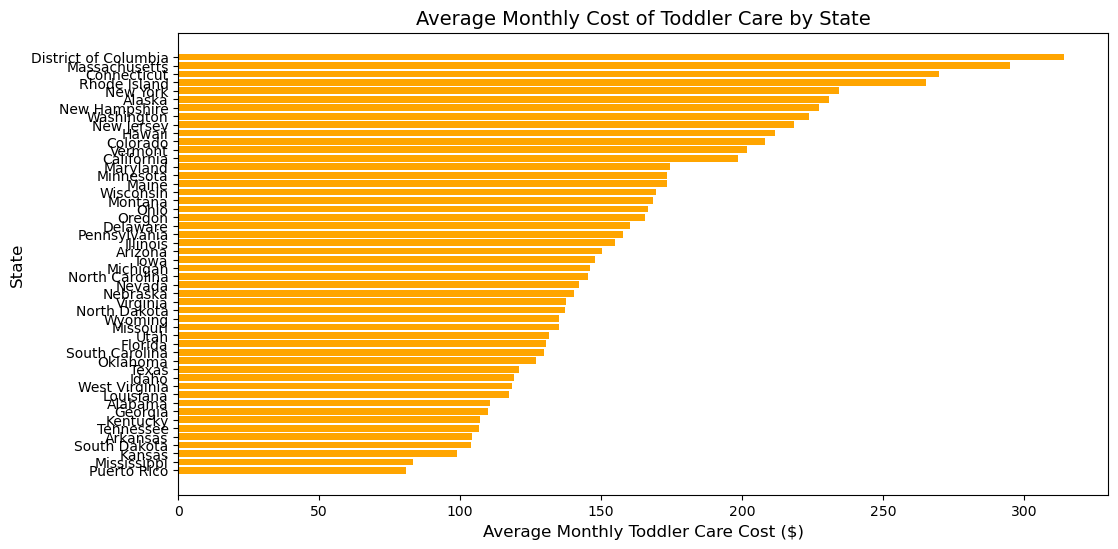

In [81]:
# Sort states by average toddler care cost
state_avg_costs = filtered_data.groupby("STATE_NAME", as_index=False)["MCTODDLER"].mean()
state_avg_costs = state_avg_costs.sort_values("MCTODDLER", ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(state_avg_costs["STATE_NAME"], state_avg_costs["MCTODDLER"], color="orange")

plt.xlabel("Average Monthly Toddler Care Cost ($)", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.title("Average Monthly Cost of Toddler Care by State", fontsize=14)
plt.gca().invert_yaxis()  # Flip the order to make highest cost appear at the top
plt.show()

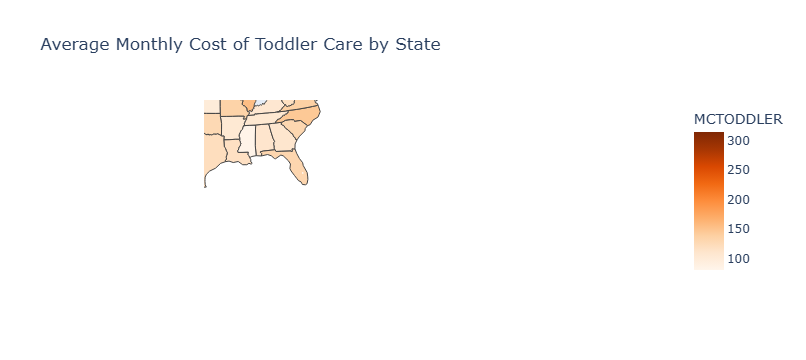

In [82]:
import plotly.express as px
# Aggregate state-level childcare cost
state_avg_costs = filtered_data.groupby("STATE_ABBREVIATION", as_index=False)["MCTODDLER"].mean()

# Create Choropleth Map
fig = px.choropleth(
    state_avg_costs,
    locations="STATE_ABBREVIATION",
    locationmode="USA-states",
    color="MCTODDLER",
    color_continuous_scale="Oranges",
    scope="usa",
    title="Average Monthly Cost of Toddler Care by State"
)

fig.show()

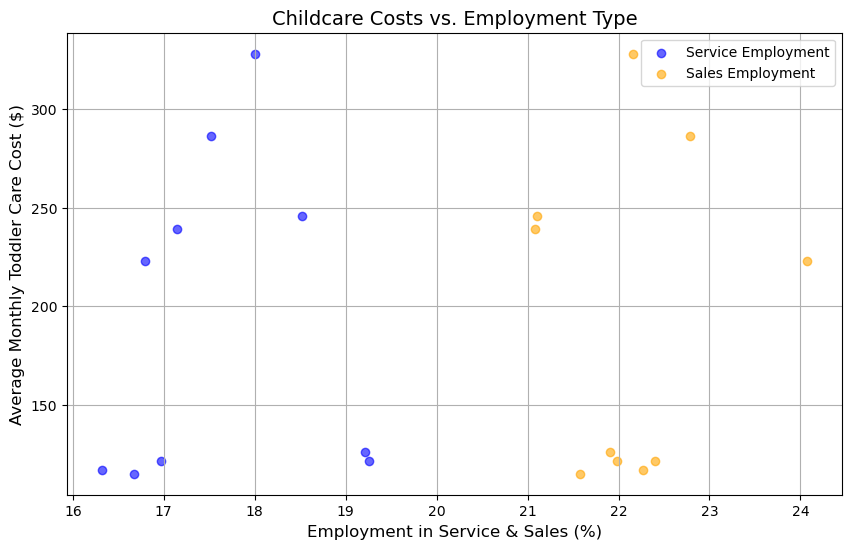

In [88]:
plt.figure(figsize=(10, 6))

# Scatter plot for employment vs childcare cost
plt.scatter(filtered_states["EMP_Service_Avg"], filtered_states["MCTODDLER_Weighted"], color="blue", alpha=0.6, label="Service Employment")
plt.scatter(filtered_states["EMP_Sales_Avg"], filtered_states["MCTODDLER_Weighted"], color="orange", alpha=0.6, label="Sales Employment")

plt.xlabel("Employment in Service & Sales (%)", fontsize=12)
plt.ylabel("Average Monthly Toddler Care Cost ($)", fontsize=12)
plt.title("Childcare Costs vs. Employment Type", fontsize=14)
plt.legend()
plt.grid(True)

plt.show()